# Analysis of SI16-5kb in IMR90 in batch

by Pu Zheng

2021.3.15

1. EM algorithm has been updated.

<a id='0'></a>
# 0. required packages for h5py

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

57268


<a id='1'></a>
# 1. Create field-of-view class

In [2]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(External.Fitting_v4)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

<module 'ImageAnalysis3.spot_tools.fitting' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\spot_tools\\fitting.py'>

<a id='1.1'></a>
## 1.1 set parameters

In [3]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb',
             'save_folder':r'\\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20200803-Corrections_3color',
             'shared_parameters':{
                     'single_im_size':[30,2048,2048],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':200,
                     'max_num_seeds': 1000,
                     'spot_seeding_th':150,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(3, 23)

<a id='1.2'></a>
## 1.2 process images into spots

In [6]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite_spots = False
overwrite_chrom = True
intensity_th = 200

raw_spots_list_list = []
spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []
cand_fov_ids = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )
    fov._save_to_file('unique') # add raw_spots into hdf5
    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite_spots,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_overwrite=False)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=3, 
                                                                   _binary_per_th=99.85, 
                                                                   _morphology_size=2,
                                                                   _overwrite=overwrite_chrom)
    fov._load_from_file('unique')

    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.25,
                                                             _cand_spot_intensity_th=intensity_th,
                                                             _save=True, 
                                                             _overwrite=overwrite_chrom)    
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    cand_fov_ids += list(np.ones(len(fov_cand_chr_spots_list), dtype=np.int) * _fov_id)
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 32 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 6.828s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segment

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\skimage\segmentation\random_walker_segmentation.py:467: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  inds_isolated_seeds, isolated_values) = _preprocess(labels)


-- find objects larger than size=50
-- 108 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 71.305s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.034s.
+ loading unique from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ finish loading unique in 0.093s. 
- start select from 108 chromosomes with loss threshold=0.25
-- remove chr id 98, percentage of lost rounds:0.731.
-- remove chr id 47, percentage of lost rounds:0.624.
-- remove chr id 14, percentage of lost rounds:0.484.
-- remove chr id 30, percentage of lost rounds:0.409.
-- remove chr id 46, percentage of lost rounds:0.333.
-- remove chr id 46, percentage of lost rounds:0.333.
-- remove chr id 10, percentage of lost rounds:0.323.
-- remove chr id 57, percentage of lost rounds:0.301.
-

-- saving unique to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_05.hdf5
--- unique attributes updated:[] in 0.004s.
-- No folder selected, allow processing all 32 folders
-- checking unique, region:[1 2 3] in 0.469s.
-- checking unique, region:[4 5 6] in 0.021s.
-- checking unique, region:[7 8 9] in 0.008s.
-- checking unique, region:[10 11 12] in 0.008s.
-- checking unique, region:[13 14 15] in 0.008s.
-- checking unique, region:[16 17 18] in 0.007s.
-- checking unique, region:[19 20 21] in 0.007s.
-- checking unique, region:[22 23 24] in 0.007s.
-- checking unique, region:[25 26 27] in 0.115s.
-- checking unique, region:[28 29 30] in 0.008s.
-- checking unique, region:[31 32 33] in 0.007s.
-- checking unique, region:[34 35 36] in 0.008s.
-- checking unique, region:[37 38 39] in 0.007s.
-- checking unique, region:[40 41 42] in 0.008s.
-- checking unique, region:[43 44 45] in 0.007s.
-- checking unique, region:[46 47 48] in 0.008s.
-- c

-- remove chr id 5, percentage of lost rounds:0.333.
-- remove chr id 43, percentage of lost rounds:0.333.
-- remove chr id 48, percentage of lost rounds:0.323.
-- remove chr id 54, percentage of lost rounds:0.323.
-- remove chr id 11, percentage of lost rounds:0.312.
-- remove chr id 25, percentage of lost rounds:0.312.
-- remove chr id 26, percentage of lost rounds:0.312.
-- remove chr id 41, percentage of lost rounds:0.312.
-- remove chr id 52, percentage of lost rounds:0.301.
-- remove chr id 59, percentage of lost rounds:0.301.
-- remove chr id 59, percentage of lost rounds:0.301.
-- remove chr id 12, percentage of lost rounds:0.290.
-- remove chr id 37, percentage of lost rounds:0.269.
-- remove chr id 57, percentage of lost rounds:0.258.
-- remove chr id 57, percentage of lost rounds:0.258.
-- 59 chromosomes are kept.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_06.hdf5
++ base attributes saved:['chrom_coords

-- checking unique, region:[58 59 60] in 0.009s.
-- checking unique, region:[61 62 63] in 0.008s.
-- checking unique, region:[64 65 66] in 0.008s.
-- checking unique, region:[67 68 69] in 0.008s.
-- checking unique, region:[70 71 72] in 0.008s.
-- checking unique, region:[73 74 75] in 0.009s.
-- checking unique, region:[76 77 78] in 0.008s.
-- checking unique, region:[79 80 81] in 0.008s.
-- checking unique, region:[82 83 84] in 0.008s.
-- checking unique, region:[85 86 87] in 0.008s.
-- checking unique, region:[88 89 90] in 0.008s.
-- checking unique, region:[91 92 93] in 0.008s.
directly return existing attribute.
-- adjust seed image with filter size=3
-- binarize image with threshold: 99.85%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 65 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 42.296s.
-- saving fov_info to file: \\10.2

++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 9.415s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_10.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_10.hdf5
++ base attributes loaded:[] in 0.004s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_10.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'cand_chrom_coords', 'channels', 'chrom_coords', 'chrom_im', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_chann

-- adjust seed image with filter size=3
-- binarize image with threshold: 99.85%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 74 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 47.901s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_11.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.034s.
+ loading unique from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_11.hdf5
++ finish loading unique in 0.077s. 
- start select from 74 chromosomes with loss threshold=0.25
-- remove chr id 73, percentage of lost rounds:0.333.
-- remove chr id 14, percentage of lost rounds:0.312.
-- remove chr id 26, percentage of lost rounds:0.312.
-- remove chr id 68, percentage of lost rounds:0.312.
-- remove chr id 68, percentage of lost

-- saving unique to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_13.hdf5
--- unique attributes updated:[] in 0.005s.
-- No folder selected, allow processing all 32 folders
-- checking unique, region:[1 2 3] in 0.071s.
-- checking unique, region:[4 5 6] in 0.008s.
-- checking unique, region:[7 8 9] in 0.050s.
-- checking unique, region:[10 11 12] in 0.008s.
-- checking unique, region:[13 14 15] in 0.008s.
-- checking unique, region:[16 17 18] in 0.008s.
-- checking unique, region:[19 20 21] in 0.008s.
-- checking unique, region:[22 23 24] in 0.008s.
-- checking unique, region:[25 26 27] in 0.008s.
-- checking unique, region:[28 29 30] in 0.008s.
-- checking unique, region:[31 32 33] in 0.008s.
-- checking unique, region:[34 35 36] in 0.007s.
-- checking unique, region:[37 38 39] in 0.008s.
-- checking unique, region:[40 41 42] in 0.007s.
-- checking unique, region:[43 44 45] in 0.008s.
-- checking unique, region:[46 47 48] in 0.008s.
-- c

-- remove chr id 63, percentage of lost rounds:0.290.
-- remove chr id 70, percentage of lost rounds:0.258.
-- 71 chromosomes are kept.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_14.hdf5
++ base attributes saved:['chrom_coords'] in 0.037s.
kept chromosomes: 71
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 32 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_15.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 11.497s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2

-- checking unique, region:[67 68 69] in 0.007s.
-- checking unique, region:[70 71 72] in 0.008s.
-- checking unique, region:[73 74 75] in 0.009s.
-- checking unique, region:[76 77 78] in 0.008s.
-- checking unique, region:[79 80 81] in 0.008s.
-- checking unique, region:[82 83 84] in 0.008s.
-- checking unique, region:[85 86 87] in 0.008s.
-- checking unique, region:[88 89 90] in 0.008s.
-- checking unique, region:[91 92 93] in 0.008s.
directly return existing attribute.
-- adjust seed image with filter size=3
-- binarize image with threshold: 99.85%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 113 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 70.340s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_16.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.117s

++ load illumination correction profile directly from savefile.
+ loading segmentation from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_18.hdf5
++ base attributes loaded:[] in 0.004s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_18.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'cand_chrom_coords', 'channels', 'chrom_coords', 'chrom_im', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'ref_im', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 72.387s.
-- saving unique to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_

-- remove chr id 22, percentage of lost rounds:0.301.
-- remove chr id 50, percentage of lost rounds:0.301.
-- remove chr id 66, percentage of lost rounds:0.290.
-- remove chr id 65, percentage of lost rounds:0.280.
-- remove chr id 65, percentage of lost rounds:0.269.
-- remove chr id 57, percentage of lost rounds:0.258.
-- 64 chromosomes are kept.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_19.hdf5
++ base attributes saved:['chrom_coords'] in 0.035s.
kept chromosomes: 64
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 32 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analy

-- checking unique, region:[76 77 78] in 0.008s.
-- checking unique, region:[79 80 81] in 0.008s.
-- checking unique, region:[82 83 84] in 0.008s.
-- checking unique, region:[85 86 87] in 0.008s.
-- checking unique, region:[88 89 90] in 0.007s.
-- checking unique, region:[91 92 93] in 0.008s.
directly return existing attribute.
-- adjust seed image with filter size=3
-- binarize image with threshold: 99.85%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 91 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 60.401s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_21.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.053s.
+ loading unique from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_21.hdf5
++ finish loading uniq

In [19]:
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=3, 
                                                                   _binary_per_th=99.8, 
                                                                   _morphology_size=2,
                                                                   _overwrite=True)

-- adjust seed image with filter size=3
-- binarize image with threshold: 99.8%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\skimage\segmentation\random_walker_segmentation.py:467: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  inds_isolated_seeds, isolated_values) = _preprocess(labels)


-- find objects larger than size=50
-- 104 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 79.033s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_22.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.050s.


In [23]:
filtered_chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.25,
                                                                  _cand_spot_intensity_th=200,
                                                                  _save=False, 
                                                                  _overwrite=True)   

- start select from 104 chromosomes with loss threshold=0.25
-- remove chr id 84, percentage of lost rounds:0.548.
-- remove chr id 30, percentage of lost rounds:0.484.
-- remove chr id 17, percentage of lost rounds:0.441.
-- remove chr id 95, percentage of lost rounds:0.355.
-- remove chr id 53, percentage of lost rounds:0.333.
-- remove chr id 92, percentage of lost rounds:0.333.
-- remove chr id 53, percentage of lost rounds:0.323.
-- remove chr id 91, percentage of lost rounds:0.323.
-- remove chr id 95, percentage of lost rounds:0.323.
-- remove chr id 15, percentage of lost rounds:0.312.
-- remove chr id 39, percentage of lost rounds:0.290.
-- remove chr id 75, percentage of lost rounds:0.290.
-- remove chr id 51, percentage of lost rounds:0.280.
-- remove chr id 88, percentage of lost rounds:0.280.
-- remove chr id 47, percentage of lost rounds:0.258.
-- remove chr id 70, percentage of lost rounds:0.258.
-- remove chr id 85, percentage of lost rounds:0.258.
-- 87 chromosomes are

In [ ]:
def chromosome_center_dists(cand_hzxys, ref_zxy=None, 
                            split_channels=False, ref_channels=None):
    """Function to calculate distance between candidate hzxys coordinates to a reference zxy """
    if split_channels and ref_channels is None:
        raise ValueError(f"ref_channels should be given if split_channels is True")
    elif len(ref_channels) != len(cand_hzxys):
        raise ValueError(f"ref_channels should have the same length as cand_hzxys")

    # generate ref_zxy
    if 

    _ct_dists = []

    if len(ref_zxy) > 3:
        _ref_zxy = np.array(ref_zxy[1:4])
    elif len(ref_zxy) == 3:
        _ref_zxy = np.array(ref_zxy)
    else:
        raise IndexError(f"ref_zxy should at least have 3 elements")
    # loop through regions
    for _hzxys in cand_hzxys:
        if len(_hzxys) == 0:
            _ct_dists.append(np.array([np.nan]))
        # only one spot per region
        elif len(np.shape(np.array(_hzxys))) == 1:
            _dist = np.linalg.norm(np.array(_hzxys)[-3:] - _ref_zxy)
            _ct_dists.append(_dist)
        # multiple spots per region
        elif len(np.shape(np.array(_hzxys))) == 2:
            _dists = np.linalg.norm(np.array(_hzxys)[:,-3:] - _ref_zxy, axis=1)
            _ct_dists.append(_dists)
        else:
            raise IndexError("Wrong input shape for cand_hzxys:_hzxys")
    
    return _ct_dists

<IPython.core.display.Javascript object>


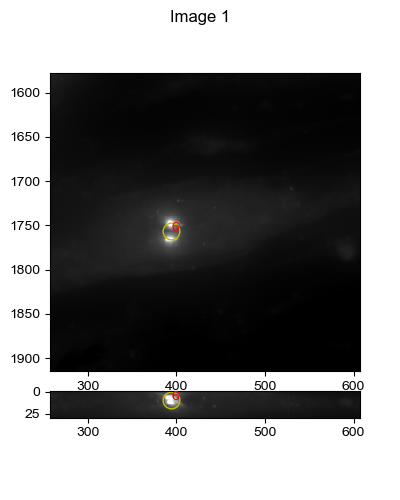

In [24]:
%matplotlib notebook
%matplotlib notebook
## visualize
coord_dict = {'coords':[np.flipud(_coord) for _coord in filtered_chrom_coords],
              'class_ids':list(np.zeros(len(filtered_chrom_coords),dtype=np.int)),
             }

visual_tools.imshow_mark_3d_v2([fov.chrom_im], 
                               given_dic=coord_dict,
                               save_file=None,
                               )


In [ ]:
# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids
dna_reg_channels = fov.unique_channels

print(f"{len(chrom_coords)} chromosomes are found.")

In [ ]:
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 3000nm
good_chr_th = 0.8 # 80% of regions should have candidate spots

sel_dna_cand_hzxys_list = []
sel_chrom_coords = []
chr_cand_pers = []
sel_chr_cand_pers = []
sel_cand_fov_ids = []

for _cand_hzxys, _chrom_coord, _fov_id in zip(dna_cand_hzxys_list, chrom_coords, cand_fov_ids):
    _chr_cand_per = 0
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th)])
            _chr_cand_per += 1
    
    _chr_cand_per *= 1/len(_cand_hzxys)
    # append
    if _chr_cand_per >= good_chr_th:
        sel_dna_cand_hzxys_list.append(_sel_cands_list)
        sel_chrom_coords.append(_chrom_coord)
        sel_chr_cand_pers.append(_chr_cand_per)
        sel_cand_fov_ids.append(_fov_id)
        
    chr_cand_pers.append(_chr_cand_per)
    
print(f"kept chromosomes: {len(sel_chrom_coords)}")

<a id='2'></a>
# 2. EM pick spots

In [ ]:
%matplotlib inline
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import _maximize_score_spot_picking_of_chr, pick_spots_by_intensities,pick_spots_by_scores, generate_reference_from_population, evaluate_differences

niter= 10
num_threads = 32
ref_chr_cts = None
# initialize
init_dna_hzxys = pick_spots_by_intensities(sel_dna_cand_hzxys_list)
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list, other_dna_scores_list = [init_dna_hzxys], [], [], []

for _iter in range(niter):
    print(f"+ iter:{_iter}")
    # E: generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1], dna_reg_ids,
        ref_channels=dna_reg_channels,
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        verbose=True,
    )
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ct_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('center dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_local_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('local dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ints.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('intensity', fontsize=8)
    plt.show()
    
    # M: pick based on scores
    sel_hzxys_list, sel_scores_list, all_scores_list, other_scores_list = \
    pick_spots_by_scores(
        sel_dna_cand_hzxys_list, dna_reg_ids,
        cand_channels=dna_reg_channels, 
        ref_hzxys_list=sel_dna_hzxys_list[-1], ref_ids=dna_reg_ids, ref_channels=dna_reg_channels,
        ref_ct_dists=ref_ct_dists, ref_local_dists=ref_local_dists, ref_ints=ref_ints, 
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        return_other_scores=True,
        verbose=True,
    )
    # check updating rate
    update_rate = evaluate_differences(sel_hzxys_list, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    # append
    sel_dna_hzxys_list.append(sel_hzxys_list)
    sel_dna_scores_list.append(sel_scores_list)
    all_dna_scores_list.append(all_scores_list)
    other_dna_scores_list.append(other_scores_list)
    
    plt.figure(figsize=(4,2), dpi=100)
    plt.hist(np.concatenate([np.concatenate(_scores) 
                       for _scores in other_scores_list]), 
             bins=np.arange(-15, 0, 0.5), alpha=0.5, label='unselected')
    plt.hist(np.ravel([np.array(_sel_scores) 
                       for _sel_scores in sel_dna_scores_list[-1]]), 
             bins=np.arange(-15, 0, 0.5), alpha=0.5, label='selected')
    plt.legend(fontsize=8)
    plt.show()
    
    if update_rate > 0.998:
        break

In [ ]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = -5
int_th = 300
bad_spot_percentage = 0.5

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    # remove spots by intensity
    _bad_inds = _kept_hzxys[:,0] < int_th
    # remove spots by scores
    _bad_inds += _scores < score_th
    #print(np.mean(_bad_inds))
    _kept_hzxys[_bad_inds] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
kept_chrom_coords = np.array(sel_chrom_coords)[kept_chr_ids]
kept_fov_ids = np.array(sel_cand_fov_ids)[kept_chr_ids]

distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

In [ ]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,len(median_distmap),20))
ax.set_ylim([0,1])
ax.set_title(f"Loss rate", fontsize=9)
plt.show()

In [ ]:
imaging_order = []
for _fd, _infos in fov.color_dic.items():
    for _info in _infos:
        if len(_info) > 0 and _info[0] == 'u':
            imaging_order.append(list(dna_reg_ids).index(int(_info[1:])))
imaging_order = np.array(imaging_order, dtype=np.int)
#kept_inds = imaging_order # plot imaging ordered regions

#kept_inds = np.where(loss_rates<0.2)[0] # plot good regions only
#kept_inds = np.where(loss_rates>0.2)[0] # plot bad regions only
kept_inds = np.arange(len(fov.unique_ids)) # plot all

%matplotlib inline

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"proB DMSO, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 20)
ax.set_xticks(_ticks)
ax.set_xticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_xlabel(f"5kb region id", fontsize=7, labelpad=2)
ax.set_yticks(_ticks)
ax.set_yticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_ylabel(f"5kb region id", fontsize=7, labelpad=2)


ax.axvline(x=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])
ax.axhline(y=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

In [ ]:
# generate full distmap
full_size = np.max(dna_reg_ids) - np.min(dna_reg_ids)+1

full_median_distmap = np.ones([full_size, full_size])*np.nan
full_median_distmap[np.arange(full_size), np.arange(full_size)] = np.zeros(len(full_median_distmap))
for _i, _id in enumerate(dna_reg_ids-np.min(dna_reg_ids)):
    full_median_distmap[_id, dna_reg_ids-np.min(dna_reg_ids)] = median_distmap[_i]
    
import matplotlib
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.4,0.4,0.4,1])

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(full_median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               cmap=median_cmap,
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0, np.max(dna_reg_ids)-np.min(dna_reg_ids), 50),
                                               tick_labels=np.arange(np.min(dna_reg_ids), np.max(dna_reg_ids),50), 
                                               figure_dpi=200)

ax.set_title(f"proB DMSO, n={len(distmap_list)}", fontsize=7.5)
ax.set_xlabel(f"5kb region ids", fontsize=7.5)
plt.show()

## 3.1 visualize single chromosome

In [ ]:
%matplotlib inline

reload(figure_tools.image)

chrom_id = 3

import matplotlib
import copy

sc_cmap = copy.copy(matplotlib.cm.get_cmap('seismic_r'))
sc_cmap.set_bad(color=[0.5,0.5,0.5,1])

#valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]
valid_inds = np.ones(len(final_dna_hzxys_list[chrom_id]), dtype=np.bool) # all spots

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(
        distmap_list[chrom_id][valid_inds][:,valid_inds], 
        color_limits=[0,600],
        ax=ax,
        cmap=sc_cmap,
        ticks=np.arange(0,150,20), 
        figure_dpi=200)
ax.set_title(f"proB bone marrow IgH+/+ chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

ax3d = figure_tools.image.chromosome_structure_3d_rendering(
        final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
        marker_edge_line_width=0,
        reference_bar_length=200, image_radius=200, 
        line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()

# 4. Save to a temp file

In [ ]:
# save picked_spots
overwrite_savefile = True

save_filename = os.path.join(fov.save_folder, f"Picked_spots_fov_{np.min(kept_fov_ids)}-{np.max(kept_fov_ids)}.pkl")

if not os.path.exists(save_filename) or overwrite_savefile:
    # assemble data dict
    picked_data = {
        'hzxys': final_dna_hzxys_list,
        'chrom_coords':kept_chrom_coords,
        'sel_scores': [_s for _s, _flag in zip(sel_dna_scores_list[-1], kept_chr_ids) if _flag],
        'other_scores': [_s for _s, _flag in zip(other_dna_scores_list[-1], kept_chr_ids) if _flag],
        'fov_ids': kept_fov_ids,
        'intensity_th': int_th,
        'score_th': score_th,
        'parameters': fov.shared_parameters,
    }
    picked_data['Notes'] = "Saved on March 16, 2021\n"

    # save
    print(f"save to file: {save_filename}")
    pickle.dump(picked_data, open(save_filename, 'wb'))

In [ ]:
#radius of gyration
rgs = [spot_tools.scoring.radius_of_gyration(_hzxys[:72,1:]) for _hzxys in final_dna_hzxys_list]
print(np.median(rgs))
plt.figure()
plt.hist(rgs, bins=np.arange(0,1000,50))
plt.show()